In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from duckreg.estimators import DuckMundlak, DuckDoubleDemeaning
import duckdb
import pyfixest as pf

np.random.seed(42)

In [2]:
def panel_dgp(
    num_units=1000,
    num_periods=30,
    num_treated=50,
    treatment_start=15,
    hetfx=False,
    base_treatment_effect=np.repeat(0, 15),
    ar_coef=0.2,  # Autoregressive coefficient for epsilon_it
    sigma_unit=1,
    sigma_time=0.5,
    sigma_epsilon = 0.5,  # Standard deviation of epsilon_it
):
    unit_intercepts = np.random.normal(0, sigma_unit, num_units)

    # Generate day-of-the-week pattern
    day_effects = np.array([-0.1, 0.1, 0, 0, 0.1, 0.5, 0.5])  # Stronger effects on weekends
    day_pattern = np.tile(day_effects, num_periods // 7 + 1)[:num_periods]

    # Generate autoregressive structure
    ar_coef_time = 0.2
    ar_noise_time = np.random.normal(0, sigma_time, num_periods)
    time_intercepts = np.zeros(num_periods)
    time_intercepts[0] = ar_noise_time[0]
    for t in range(1, num_periods):
        time_intercepts[t] = ar_coef_time * time_intercepts[t - 1] + ar_noise_time[t]
    # Combine day-of-the-week pattern and autoregressive structure
    time_intercepts = day_pattern + time_intercepts - np.mean(time_intercepts)
    # Generate autoregressive noise for each unit
    ar_noise = np.random.normal(0, sigma_epsilon, (num_units, num_periods))
    noise = np.zeros((num_units, num_periods))
    noise[:, 0] = ar_noise[:, 0]
    for t in range(1, num_periods):
        noise[:, t] = ar_coef * noise[:, t - 1] + ar_noise[:, t]
    # N X T matrix of potential outcomes under control
    Y0 = unit_intercepts[:, np.newaxis] + time_intercepts[np.newaxis, :] + noise
    # Generate the base treatment effect (concave structure)
    # Generate heterogeneous multipliers for each unit
    if hetfx:
        heterogeneous_multipliers = np.random.uniform(0.5, 1.5, num_units)
    else:
        heterogeneous_multipliers = np.ones(num_units)

    # Create a 2D array to store the heterogeneous treatment effects
    treatment_effect = np.zeros((num_units, num_periods - treatment_start))
    for i in range(num_units):
        treatment_effect[i, :] = heterogeneous_multipliers[i] * base_treatment_effect

    # random assignment
    treated_units = np.random.choice(num_units, num_treated, replace=False)
    treatment_status = np.zeros((num_units, num_periods), dtype=bool)
    treatment_status[treated_units, treatment_start:] = True

    # Apply the heterogeneous treatment effect to the treated units
    Y1 = Y0.copy()
    for t in range(treatment_start, num_periods):
        Y1[:, t][treatment_status[:, t]] += treatment_effect[:, t - treatment_start][
            treatment_status[:, t]
        ]

    # Create a DataFrame
    unit_ids = np.repeat(np.arange(num_units), num_periods)
    time_ids = np.tile(np.arange(num_periods), num_units)
    W_it = treatment_status.flatten()
    Y_it = np.where(W_it, Y1.flatten(), Y0.flatten())
    unit_intercepts_flat = np.repeat(unit_intercepts, num_periods)
    time_intercepts_flat = np.tile(time_intercepts, num_units)
    df = pd.DataFrame(
        {
            "unit_id": unit_ids,
            "time_id": time_ids,
            "W_it": W_it.astype(int),
            "Y_it": Y_it,
            "unit_intercept": unit_intercepts_flat,
            "time_intercept": time_intercepts_flat,
        }
    )
    # assign units to ever treated if the max of W_it is 1
    df["ever_treated"] = df.groupby("unit_id")["W_it"].transform("max")
    # label cohorts
    df['cohort'] = df.query("W_it == 1").groupby('unit_id')['time_id'].transform('min')
    df['cohort'] = df['cohort'].fillna(0)
    df['cohort'] = df.groupby('unit_id')['cohort'].transform('max')
    return df

# Function to create and populate DuckDB database
def create_duckdb_database(df, db_name="large_dataset.db", table="panel_data"):
    conn = duckdb.connect(db_name)
    conn.execute(f"DROP TABLE IF EXISTS {table}")
    conn.execute(f"CREATE TABLE {table} AS SELECT * FROM df")
    conn.close()
    print(f"Data loaded into DuckDB database: {db_name}")

In [3]:
num_periods = 30
treat_start_period = 15
treat_effect_vector= 0.2 * np.log(2 * np.arange(1, num_periods - treat_start_period + 1))
treat_effect_vector[8:] = 0 # switch off effects after a week
sigma_i, sigma_t = 2, 1
treat_effect_vector.mean()

np.float64(0.21533040462966416)

In [4]:
df = panel_dgp(
    num_units=100_000, num_treated= 50_000,
    num_periods=30,
    treatment_start = treat_start_period,
    hetfx=False,
    base_treatment_effect = treat_effect_vector,
    sigma_unit = sigma_i, sigma_time = sigma_t,
)

db_name = 'event_study_data.db'
create_duckdb_database(df, db_name)
df = df.merge(
    pd.get_dummies(df["time_id"], prefix="time"), left_index=True, right_index=True
)
time_dummies = df.filter(regex = r"time_\d").columns

Data loaded into DuckDB database: event_study_data.db


### in-memory estimation

Eq 5.13 in Wooldridge

$$
Y_{it} = \alpha + \xi d_i + \beta_q(d_i fq_t) + \dots + \beta_T(d_i fT_t) + \theta_0 fq_t + \theta_T fT_t + \epsilon_{it}
$$

where $\beta$ coefficients are the event study coefficients.

In [5]:
%%time
print(ff := f"""
        Y_it ~ ever_treated*({' + '.join(time_dummies)})
         """)
m = pf.feols(ff, data = df)


        Y_it ~ ever_treated*(time_0 + time_1 + time_2 + time_3 + time_4 + time_5 + time_6 + time_7 + time_8 + time_9 + time_10 + time_11 + time_12 + time_13 + time_14 + time_15 + time_16 + time_17 + time_18 + time_19 + time_20 + time_21 + time_22 + time_23 + time_24 + time_25 + time_26 + time_27 + time_28 + time_29)
         


/home/alal/Desktop/code/econometrics/pyfixest/pyfixest/estimation/feols_.py:2324: UserWarning: 
            The following variables are collinear: ['time_29'].
            The variables are dropped from the model.
            
  warnings.warn(


CPU times: user 5.11 s, sys: 1.41 s, total: 6.52 s
Wall time: 3.66 s


/home/alal/Desktop/code/econometrics/pyfixest/pyfixest/estimation/feols_.py:727: RuntimeWarning: invalid value encountered in sqrt
  self._se = np.sqrt(np.diagonal(_vcov))


Event study regression

In [6]:
%%time
m2 = pf.feols("""
              Y_it ~ i(time_id, ever_treated,  ref = 14) |
                unit_id + time_id
              """,
              df
             )
evstudy_coefs = m2.coef().values
# insert zero in reference period
evstudy_coefs = np.insert(evstudy_coefs, 14, 0)

CPU times: user 14.9 s, sys: 1.32 s, total: 16.2 s
Wall time: 7.26 s


/home/alal/Desktop/code/econometrics/pyfixest/pyfixest/estimation/feols_.py:727: RuntimeWarning: invalid value encountered in sqrt
  self._se = np.sqrt(np.diagonal(_vcov))


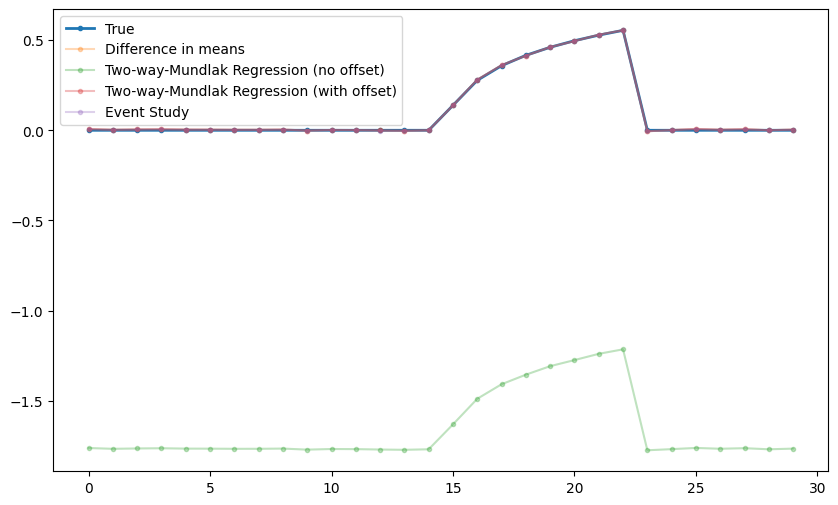

In [7]:
p0 = np.r_[np.zeros(15), treat_effect_vector]
p1 = m.coef().filter(regex=r"ever_treated:time_\d").values


p2 = (
    df.groupby(["ever_treated", "time_id"])["Y_it"]
    .mean()
    .unstack()
    .diff(axis=0)
    .iloc[1, :]
    .values
)
f, ax = plt.subplots(figsize = (10, 6))
ax.plot(p0, marker=".", label="True", linewidth=2)
ax.plot(p2, marker=".", alpha=0.3, label="Difference in means")
ax.plot(p1, marker=".", alpha=0.3, label="Two-way-Mundlak Regression (no offset)")
ax.plot(
    p1 + m.coef().filter(regex="ever_treated$").values,
    marker=".",
    alpha=0.3,
    label="Two-way-Mundlak Regression (with offset)",
)
ax.plot(evstudy_coefs, marker=".", alpha=0.3, label="Event Study")
ax.legend()

We get the same coefficient once we offset the $\beta$ vector with $\xi$. The wooldridge paper claims that the $\beta$ coefficients should be identical to the event study coefficients without the $\xi$ offset. This is not true. 

So, the gameplan is to groupby (`on_hot_encoded_cohort_id, one_hot_encoded_time_id, on_hot_encoded_cohort_id X one_hot_encoded_time_id`) and run the compressed regression by weighted least squares.

### compress (in pandas for now)

In [8]:
%%time
cohort_dummies = pd.get_dummies(df['cohort'], drop_first=True).astype(int).values
time_dummies = pd.get_dummies(df['time_id']).astype(int).values

# cohort dummies, time dummies, and interaction
Xmat = np.c_[
    np.ones(df.shape[0]),
    cohort_dummies,
    cohort_dummies[:, [0]] * time_dummies,
    time_dummies,
]
y = df["Y_it"].values
dfnew = pd.DataFrame(
    np.c_[y, Xmat], columns=["Y_it"] + [f"X{i}" for i in range(Xmat.shape[1])]
)
agg_df = dfnew.groupby(list(dfnew.columns[1:]))['Y_it'].agg(['sum', 'count']).reset_index()
agg_df['y_mean'] = agg_df['sum'] / agg_df['count']

CPU times: user 2 s, sys: 779 ms, total: 2.78 s
Wall time: 2.79 s


In [9]:
%%time
print(ff := f"y_mean~0+{'+'.join(dfnew.filter(like = 'X').columns)}")
m_agg = pf.feols(ff, data = agg_df, weights = 'count', weights_type='fweights')
coefs = m_agg.coef()
compressed_coefs = coefs.iloc[2:31] + coefs['X1']

y_mean~0+X0+X1+X2+X3+X4+X5+X6+X7+X8+X9+X10+X11+X12+X13+X14+X15+X16+X17+X18+X19+X20+X21+X22+X23+X24+X25+X26+X27+X28+X29+X30+X31+X32+X33+X34+X35+X36+X37+X38+X39+X40+X41+X42+X43+X44+X45+X46+X47+X48+X49+X50+X51+X52+X53+X54+X55+X56+X57+X58+X59+X60+X61
CPU times: user 175 ms, sys: 159 ms, total: 334 ms
Wall time: 333 ms


/home/alal/Desktop/code/econometrics/pyfixest/pyfixest/estimation/feols_.py:2324: UserWarning: 
            The following variables are collinear: ['X0', 'X31', 'X61'].
            The variables are dropped from the model.
            
  warnings.warn(


/home/alal/Desktop/code/econometrics/pyfixest/pyfixest/estimation/feols_.py:727: RuntimeWarning: invalid value encountered in sqrt
  self._se = np.sqrt(np.diagonal(_vcov))


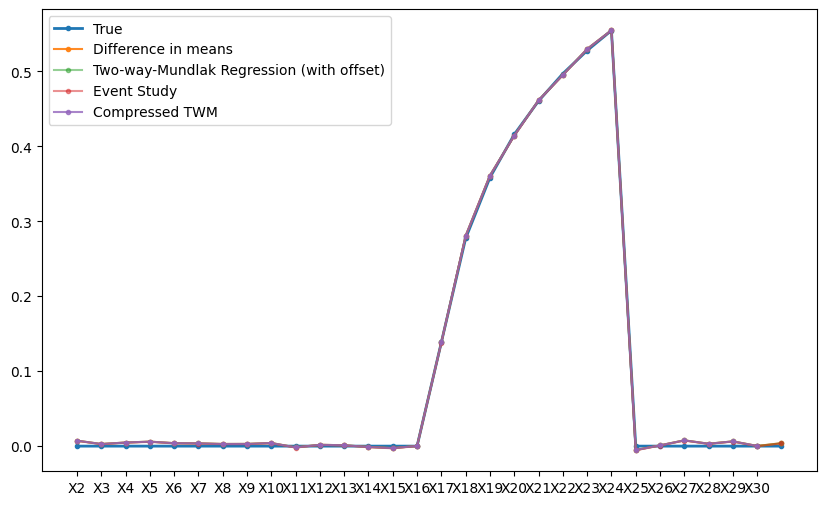

In [10]:
p0 = np.r_[np.zeros(15), treat_effect_vector]
p1 = m.coef().filter(regex=r"ever_treated:time_\d").values
p2 = (
    df.groupby(["ever_treated", "time_id"])["Y_it"]
    .mean()
    .unstack()
    .diff(axis=0)
    .iloc[1, :]
    .values
)

f, ax = plt.subplots(figsize=(10, 6))
ax.plot(p0, marker=".", label="True", linewidth=2)
ax.plot(p2, marker=".", alpha=0.9, label="Difference in means")
ax.plot(
    p1 + m.coef().filter(regex="ever_treated$").values,
    marker=".",
    alpha=0.5,
    label="Two-way-Mundlak Regression (with offset)",
)
ax.plot(evstudy_coefs, marker=".", alpha=0.5, label="Event Study")
ax.plot(compressed_coefs, marker=".", alpha=0.8, label="Compressed TWM")
ax.legend()

We recover the event study coefficients with compressed data. Now, we need implement the one-hot-encoding steps above in duckdb.

## Duckdb queries

In progress